# Import

In [7]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
import pandas as pd
from scipy.constants import c
from scipy.optimize import curve_fit, minimize, differential_evolution
from Genetic_algorithm import generate_Initial_Parameters
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm
import warnings
import time as ti
from functools import partial

# Example with PS kicker KFA21
I want to study the vertical dipolar component of the impedance but it also works with the other components of course

In [65]:
#Studied component
component = "Zdipx"

#Number of resonators
Nres = 3

impedance_file = pd.read_csv('PE.KFA79_CST_2015_10GHz.imp', 
                             sep='\s+', index_col=False, 
                             names=["f", "Re(Zdipx)", "Im(Zdipx)", 
                                    "Re(Zdipy)", "Im(Zdipy)",
                                    "Re(Zquadx)", "Im(Zquadx)",
                                    "Re(Zquady)", "Im(Zquady)"], header=0)

frequency_data = impedance_file['f'].to_numpy() #frequencies in GHz
impedance_data = np.array(impedance_file['Re({})'.format(component)] + \
                          1j*impedance_file['Im({})'.format(component)])

wake_data = pd.read_csv('PE.KFA79_CST_2015_10GHz.wake', 
                        sep='\s+', index_col=False, names=["t", "Wdipx", "Wdipy",
                                                           "Wquadx", "Wquady"])

wake_data = wake_data.loc[wake_data['t'] >= 0]
t_array = np.array(wake_data['t'])
Wt_array = np.array(wake_data[component.replace('Z','W')])

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rt_min, Rtmax), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """
bounds = [(-7e5, 7e5), (0, 20), (0, 10e9)]
parameterBounds = [(-7e5, 7e5), (0, 20), (1e-1, 10e9)] + (Nres-1)*bounds

In [66]:
GA_model = GeneticAlgorithm(frequency_data, impedance_data, 
                        t_array, Wt_array, 
                        N_resonators=Nres, parameterBounds=parameterBounds,
                        minimizationFunction=sumOfSquaredError, fitFunction=n_Resonator_transverse_imp)
GA_model.check_impedance_data()

In [67]:
%%time
GA_model.run_geneticAlgorithm(maxiter=3000, popsize=100, tol=0.01, 
                              mutation=(0.1, 0.6), crossover_rate=0.8,
                              debug=True)

 Convergence to optimal solution : [####################] 100%
Resonator 1
Rt = -9.13e+03 [Ohm/m], Q = 1.64, fres = 1.83e+09 [Hz]
------------------------------------------------------------
Resonator 2
Rt = 2.11e+04 [Ohm/m], Q = 2.34, fres = 9.49e+08 [Hz]
------------------------------------------------------------
Resonator 3
Rt = 2.85e+04 [Ohm/m], Q = 0.72, fres = 1.81e+09 [Hz]
------------------------------------------------------------
CPU times: user 3.9 s, sys: 1.24 s, total: 5.14 s
Wall time: 5.6 s


In [68]:
%%time
GA_model.run_minimizationAlgorithm(margin=0.5)

Method for minimization : L-BFGS-B
CPU times: user 17.2 ms, sys: 2.18 ms, total: 19.4 ms
Wall time: 18.8 ms


In [69]:
GA_model.geneticParameters.reshape(-1, 3)

array([[-9.12599700e+03,  1.63729539e+00,  1.82546464e+09],
       [ 2.11458094e+04,  2.34228710e+00,  9.48674263e+08],
       [ 2.84606061e+04,  7.23844971e-01,  1.81101292e+09]])

In [70]:
GA_model.minimizationParameters.reshape(-1, 3)

array([[-9.11055850e+03,  1.64006521e+00,  1.82546464e+09],
       [ 2.11815819e+04,  2.33832464e+00,  9.48674263e+08],
       [ 2.85087530e+04,  7.22620438e-01,  1.81101292e+09]])

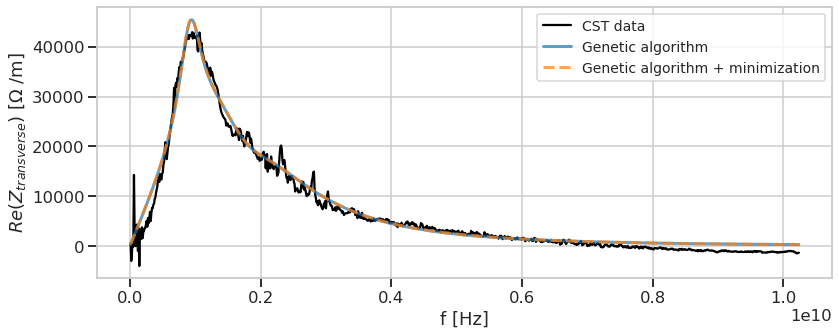

In [71]:
#Plot real part of impedance
sns.set_style(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_context('talk')

fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model.frequency_data, GA_model.impedance_data.real, "black", label='CST data')
try:
    ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.geneticParameters.reshape(-1, 3)))).real,
             lw = 3, label='Genetic algorithm', alpha=0.7)
except:
    pass
ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Genetic algorithm + minimization', alpha=0.7)

#ax0.set_xlim(0.682e9, 0.692e9)
#ax0.set_xlim(1.2e9, 1.27e9)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

fig.tight_layout()

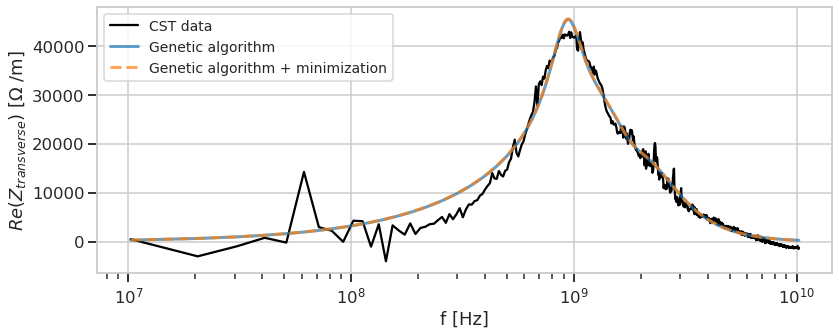

In [72]:
#Plot real part of impedance
sns.set_style(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_context('talk')

fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model.frequency_data, GA_model.impedance_data.real, "black", label='CST data')
try:
    ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.geneticParameters.reshape(-1, 3)))).real,
             lw = 3, label='Genetic algorithm', alpha=0.7)
except:
    pass
ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Genetic algorithm + minimization', alpha=0.7)

#ax0.set_xlim(0.682e9, 0.692e9)
#ax0.set_xlim(1.2e9, 1.27e9)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xscale('log')

fig.tight_layout()

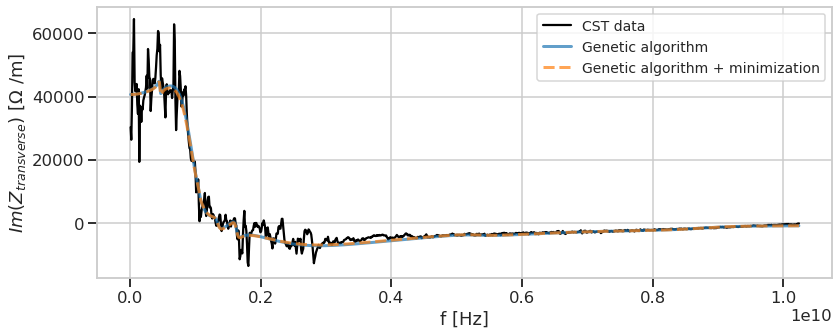

In [43]:
#Plot imaginary part of impedance

fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(frequency_data, impedance_data.imag, "black", label='CST data')
try:
    ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.geneticParameters.reshape(-1, 3)))).imag,
             lw = 3, label='Genetic algorithm', alpha=0.7)
except:
    pass
ax0.plot(GA_model.frequency_data, GA_model.fitFunction(GA_model.frequency_data, dict(enumerate(GA_model.minimizationParameters.reshape(-1, 3)))).imag,
         lw = 3, linestyle='--', label='Genetic algorithm + minimization', alpha=0.7)

#ax0.set_xlim(0.682e9, 0.692e9)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Im(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

fig.tight_layout()

# Crosscheck with the wake
Here I load the CST wake and compare with the wake function reconstruction obtained from the fitted resonators parameters

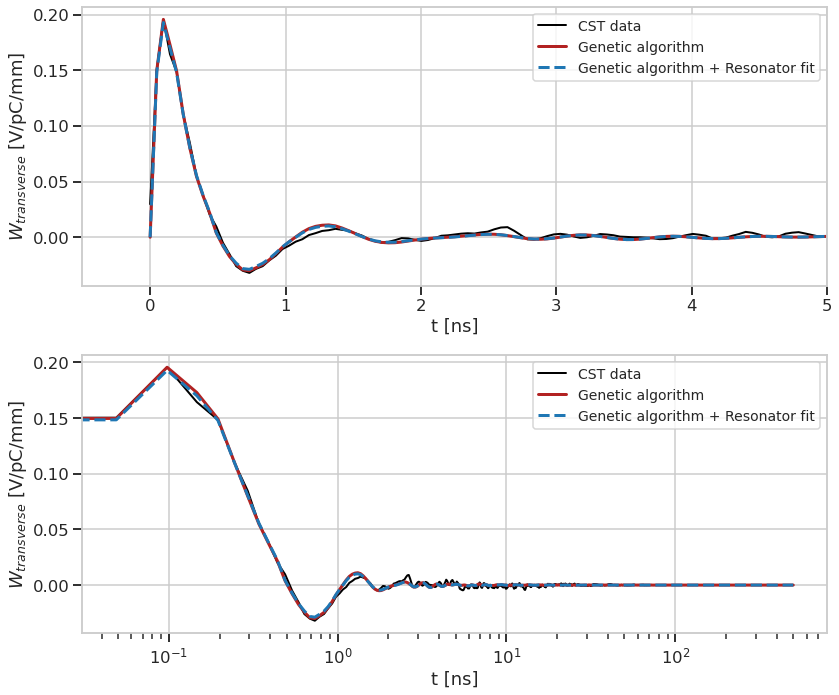

In [44]:
sns.set_style(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_context('talk')


fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(GA_model.time_data*1e9, GA_model.wake_data, "black", lw=2, label='CST data')
ax0.plot(GA_model.time_data*1e9, n_Resonator_transverse_wake(GA_model.time_data, 
                                                                            dict(enumerate(GA_model.geneticParameters.reshape(-1, 3))))*1e-15,
         lw = 3, color='firebrick', label='Genetic algorithm')
ax0.plot(GA_model.time_data*1e9, n_Resonator_transverse_wake(GA_model.time_data, 
                                                             dict(enumerate(GA_model.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')


ax1.plot(GA_model.time_data*1e9, GA_model.wake_data, "black", lw=2, label='CST data')
ax1.plot(GA_model.time_data*1e9, n_Resonator_transverse_wake(GA_model.time_data, 
                                                             dict(enumerate(GA_model.geneticParameters.reshape(-1, 3))))*1e-15,
         lw = 3, color='firebrick', label='Genetic algorithm')
ax1.plot(GA_model.time_data*1e9, n_Resonator_transverse_wake(GA_model.time_data, 
                                                             dict(enumerate(GA_model.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')
ax1.set_xscale('log')

ax0.set_xlabel('t [ns]')
ax1.set_xlabel('t [ns]')

ax0.set_ylabel('$W_{transverse}$ [V/pC/mm]')
ax1.set_ylabel('$W_{transverse}$ [V/pC/mm]')

ax0.set_xlim(-0.5, 5)

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

fig.tight_layout()

In [33]:
"""R_shunt = 1e7
Q = 1
f_res = 3e9

t_array = np.linspace(0, 262, 200000, endpoint=True)
W_array = n_Resonator_transverse_wake(t_array*1e-9, *[R_shunt, Q, f_res])*1e-15

plt.figure()
plt.plot(t_array, W_array)
plt.xlim(-2, 30)

dfw = pd.DataFrame()
dfw['t'] = t_array
dfw['wxdip'] = W_array
dfw['wydip'] = 0.*W_array
dfw['wxquad'] = -W_array
dfw['wyquad'] = 0.*W_array

dfw.head()"""

"R_shunt = 1e7\nQ = 1\nf_res = 3e9\n\nt_array = np.linspace(0, 262, 200000, endpoint=True)\nW_array = n_Resonator_transverse_wake(t_array*1e-9, *[R_shunt, Q, f_res])*1e-15\n\nplt.figure()\nplt.plot(t_array, W_array)\nplt.xlim(-2, 30)\n\ndfw = pd.DataFrame()\ndfw['t'] = t_array\ndfw['wxdip'] = W_array\ndfw['wydip'] = 0.*W_array\ndfw['wxquad'] = -W_array\ndfw['wyquad'] = 0.*W_array\n\ndfw.head()"

In [34]:
#dfw.to_csv(r'/eos/user/s/sjoly/PS_wake_imp_files/BBR_3GHz_10MOhm.wake', sep='\t', index=False, header=False)